In [1]:
#Importing Packages
import xarray as xr
import cartopy.crs as ccrs
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import skgstat as skg

from src.helper_functions import grid_coords_to_2d_latlon_coords
from src.helper_functions import create_mask

In [2]:
#Loading climate data
base_path = '/home/jez/Bias_Correction/'
climate_path = f'{base_path}data/ProcessedData/MetUM_Daily_TAS.nc'
mask_path = f'{base_path}data/ProcessedData/MetUM_044_Masks.nc'

ds_climate = xr.open_dataset(climate_path)
ds_mask = xr.open_dataset(mask_path)

ds = xr.merge([ds_climate,ds_mask])


ERROR:fiona._env:PROJ: proj_identify: /home/jez/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


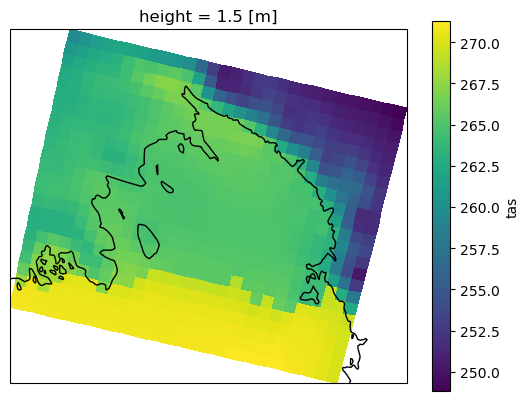

In [3]:
#Plotting Masked Climate Data and Antarctica Shapefile and Region Shapefile
map_proj = ccrs.Orthographic(central_longitude=0.0, central_latitude=-90, globe=None)

da = ds.tas.isel(time=(ds.time.dt.month == 1))
masked_da = da.where(ds.region_mask)
masked_da = masked_da.dropna('grid_latitude','all').dropna('grid_longitude','all')

masked_da.mean('time').plot(x='longitude',y='latitude',
    subplot_kws={"projection": map_proj},
    transform=ccrs.PlateCarree())

plt.gca().coastlines()

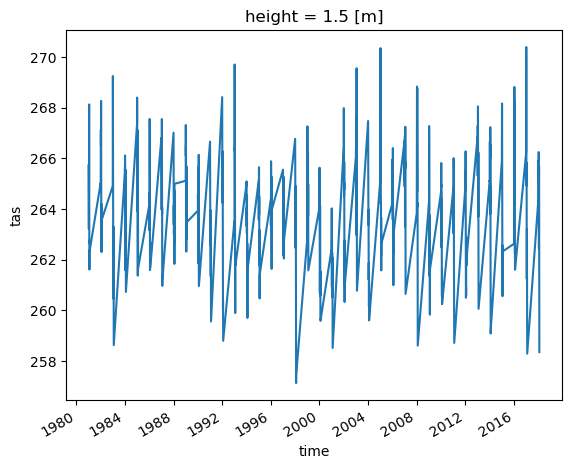

In [4]:
masked_da.mean(['grid_latitude','grid_longitude']).reset_index('time').plot()

In [5]:
def remove_outliers(da, dims=None, perc=[0.05,0.95]):
  lower_threshold = da.quantile(perc[0],dim=dims)
  upper_threshold = da.quantile(perc[1],dim=dims)
  outlier_condition = (da > upper_threshold) | (da < lower_threshold)

  return(da.where(outlier_condition==False))

In [25]:
masked_da_nooutliers = remove_outliers(masked_da.mean('time'), dims=['grid_latitude','grid_longitude'], perc=[0.05,0.95])

ERROR:fiona._env:PROJ: proj_identify: /home/jez/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


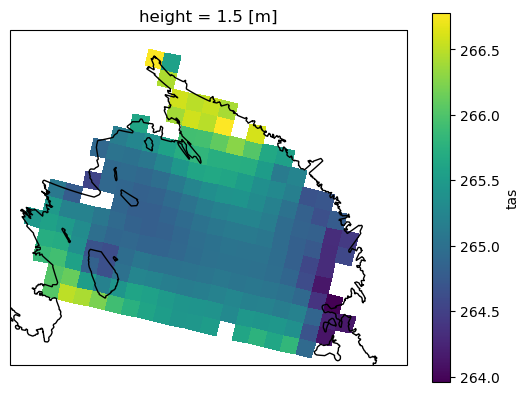

In [6]:
#Plotting Masked Climate Data and Antarctica Shapefile and Ross Ice Shelf Shapefile
map_proj = ccrs.Orthographic(central_longitude=0.0, central_latitude=-90, globe=None)

da = ds.tas.isel(time=(ds.time.dt.month == 1))
masked_da = da.where(ds.ross_mask)
masked_da_nooutliers = remove_outliers(masked_da.mean('time'), dims=['grid_latitude','grid_longitude'], perc=[0.02,0.98])
masked_da_nooutliers = masked_da_nooutliers.dropna('grid_latitude','all').dropna('grid_longitude','all')

masked_da_nooutliers.plot(x='longitude',y='latitude',
    subplot_kws={"projection": map_proj},
    transform=ccrs.PlateCarree())

plt.gca().coastlines()

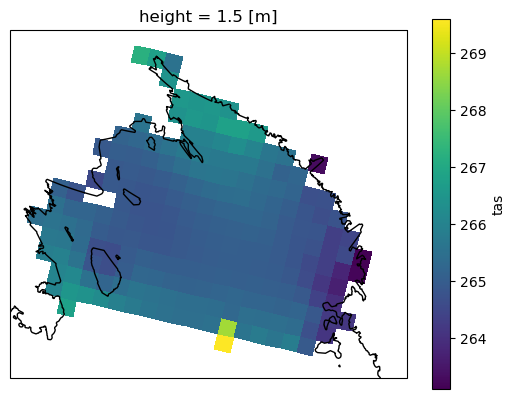

In [7]:
#Plotting Masked Climate Data and Antarctica Shapefile and Ross Ice Shelf Shapefile
map_proj = ccrs.Orthographic(central_longitude=0.0, central_latitude=-90, globe=None)

da = ds.tas.isel(time=(ds.time.dt.month == 1))
masked_da = da.where(ds.ross_mask)
masked_da = masked_da.dropna('grid_latitude','all').dropna('grid_longitude','all')

masked_da.mean('time').plot(x='longitude',y='latitude',
    subplot_kws={"projection": map_proj},
    transform=ccrs.PlateCarree())

plt.gca().coastlines()

In [100]:
#Masking dataset and filtering to Jan 
ds_jan = ds.isel(time=(ds.time.dt.month == 1))

ds_jan['Mean Temperature'] = ds_jan['tas'].mean(['time'])
ds_jan['Variance Temperature'] = ds_jan['tas'].var(['time'])

params = ['Mean Temperature','Variance Temperature']
ds_jan = ds_jan[params+['ross_mask']]

ds_jan = ds_jan.stack(sites=('grid_latitude', 'grid_longitude'))
ds_jan_masked = ds_jan.where(ds_jan.ross_mask,drop=True)

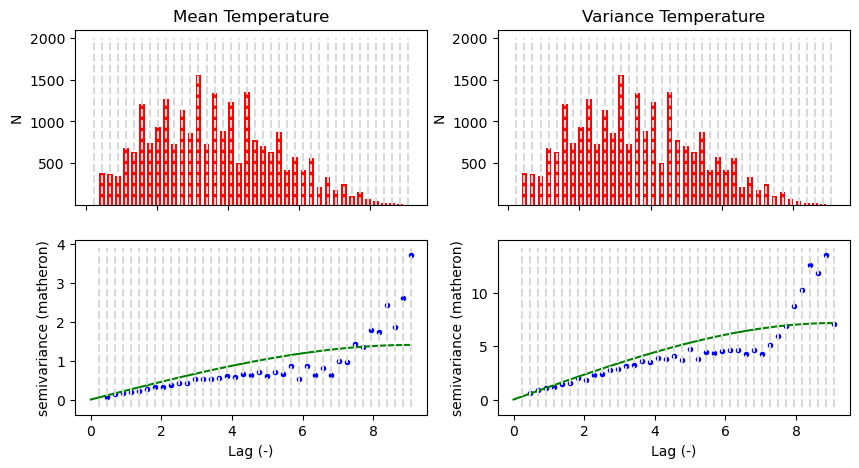

In [101]:
#Plot Semivariograms for Parameters (Ross Mask)
fig, axs = plt.subplots(2,2,figsize=(10,5))

for param in params:
    da = ds_jan_masked[param]#.dropna('Station_Lower')
    x,y = da.grid_latitude,da.grid_longitude
    coords = np.dstack([x,y]).reshape(-1,2)
    semivariogram = skg.Variogram(coords, da.data,n_lags=40)
    semivariogram.plot(axes=axs[:,params.index(param)][::-1])
    axs[:,params.index(param)][0].set_title(param)
plt.show()

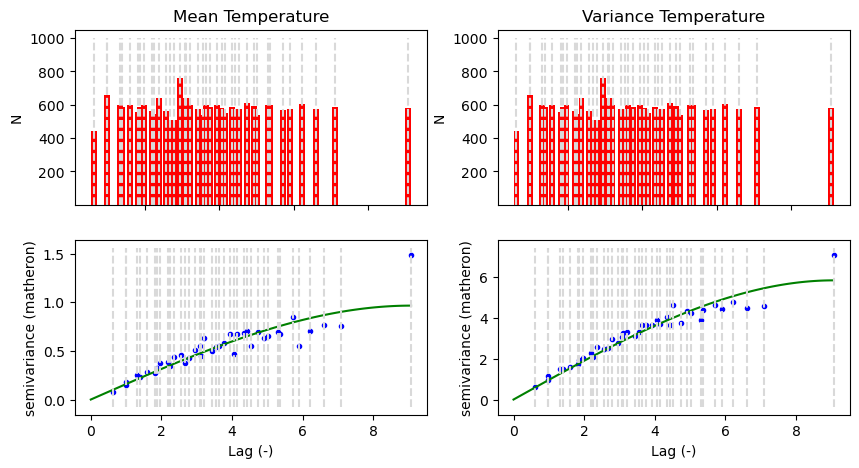

In [102]:
#Plot Semivariograms for Parameters (Ross Mask) - Uniform Bins
fig, axs = plt.subplots(2,2,figsize=(10,5))

for param in params:
    da = ds_jan_masked[param]#.dropna('Station_Lower')
    x,y = da.grid_latitude,da.grid_longitude
    coords = np.dstack([x,y]).reshape(-1,2)
    semivariogram = skg.Variogram(coords, da.data,n_lags=40,bin_func='uniform')
    semivariogram.plot(axes=axs[:,params.index(param)][::-1])
    axs[:,params.index(param)][0].set_title(param)
plt.show()

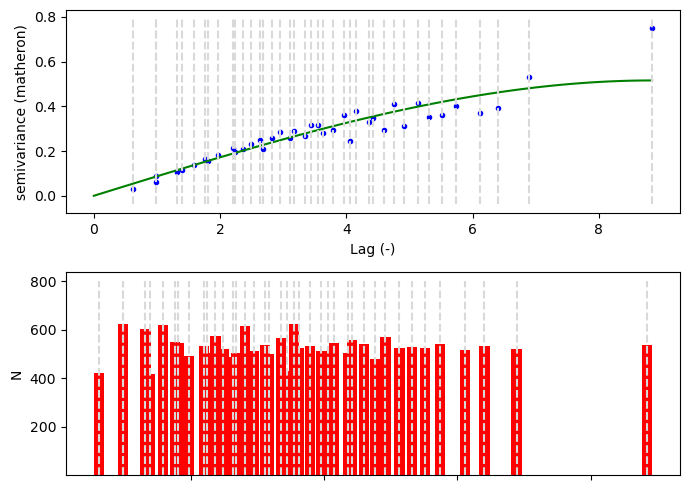

In [48]:
#Plot Semivariograms for Parameters (Ross Mask) - Uniform Bins
fig, axs = plt.subplots(2,1,figsize=(7,5))

da = masked_da_nooutliers.stack(site=('grid_latitude','grid_longitude')).dropna('site')
x,y = da.grid_latitude,da.grid_longitude
coords = np.dstack([x,y]).reshape(-1,2)
semivariogram = skg.Variogram(coords, da.data,n_lags=40,bin_func='uniform')
semivariogram.plot(axes=axs)
plt.tight_layout()
plt.show()

In [ ]:
masked_da_nooutliers = remove_outliers(masked_da.mean('time'), dims=['grid_latitude','grid_longitude'], perc=[0.05,0.95])

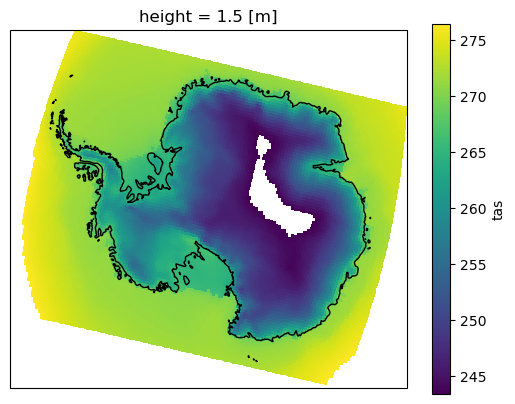

In [8]:
#Plotting Masked Climate Data and Antarctica Shapefile and Ross Ice Shelf Shapefile
map_proj = ccrs.Orthographic(central_longitude=0.0, central_latitude=-90, globe=None)

da = ds.tas.isel(time=(ds.time.dt.month == 1))
da_nooutliers = remove_outliers(da.mean('time'), dims=['grid_latitude','grid_longitude'], perc=[0.02,0.98])
da_nooutliers = da_nooutliers.dropna('grid_latitude','all').dropna('grid_longitude','all')

da_nooutliers.plot(x='longitude',y='latitude',
    subplot_kws={"projection": map_proj},
    transform=ccrs.PlateCarree())

plt.gca().coastlines()

In [10]:
da

<xarray.DataArray 'tas' (site: 11854)>
array([276.3177 , 276.10797, 275.90024, ..., 275.0384 , 275.17856,
       275.3209 ], dtype=float32)
Coordinates:
    height          float64 1.5
    latitude        (site) float64 -59.64 -59.95 -60.26 ... -56.33 -56.0 -55.67
    longitude       (site) float64 -122.3 -122.8 -123.4 ... 61.51 61.95 62.37
  * site            (site) object MultiIndex
  * grid_latitude   (site) float32 -21.56 -21.56 -21.56 ... 21.12 21.12 21.12
  * grid_longitude  (site) float32 157.6 158.0 158.4 158.9 ... 206.4 206.8 207.3

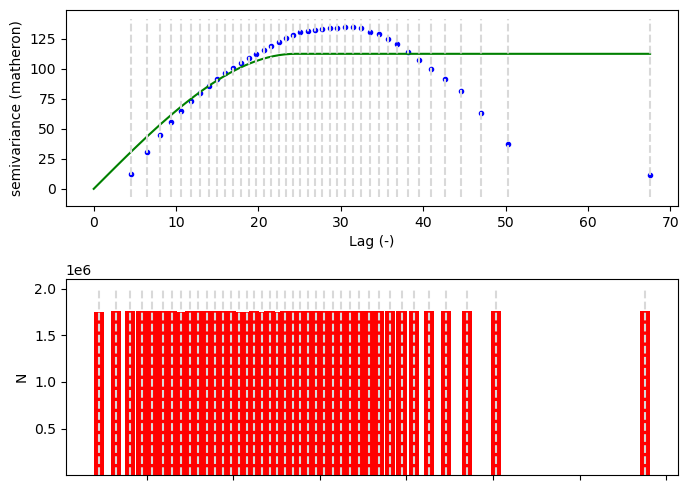

In [9]:
#Plot Semivariograms for Parameters (Ross Mask) - Uniform Bins
fig, axs = plt.subplots(2,1,figsize=(7,5))
da = da_nooutliers.stack(site=('grid_latitude','grid_longitude')).dropna('site')
x,y = da.grid_latitude,da.grid_longitude
coords = np.dstack([x,y]).reshape(-1,2)
semivariogram = skg.Variogram(coords, da.data,n_lags=40,bin_func='uniform')
semivariogram.plot(axes=axs)
plt.tight_layout()
plt.show()